In [1]:
import os
import boto3
import json
import time, random 
import uuid, string
os.environ["OPENAI_API_KEY"]="SK---"
os.environ["AWS_ACCESS_KEY_ID"]="..."
os.environ["AWS_SECRET_ACCESS_KEY"]="..."
os.environ["BEDROCK_ACCESS_KEY"]="..."
os.environ["BEDROCK_SECRET_KEY"]="..."
os.environ["BEDROCK_REGION"]= "us-west-2"
region_name = 'us-west-2'

## Initialize Manager

In [2]:
from llmstudio_core.agents import AgentManagerCore
bedrock = AgentManagerCore("bedrock")

In [3]:
bedrock

## Create Policies for Invoking Models

In [6]:
foundationModel = 'anthropic.claude-3-5-sonnet-20241022-v2:0'
iam = boto3.client('iam')
# Generate a random suffix for unique naming
randomSuffix = "".join(
    random.choices(string.ascii_uppercase + string.digits, k=5)
)


print("Creating the IAM policy and role...")

# Define IAM trust policy
trustPolicy = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                "Service": "bedrock.amazonaws.com"
            },
            "Action": "sts:AssumeRole"
        }
    ]
}

# Define IAM policy for invoking the foundation model
policy = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "bedrock:InvokeModel"
            ],
            "Resource": [
                f"arn:aws:bedrock:{region_name}::foundation-model/{foundationModel}"
            ]
        }
    ]
}

role_name = f"test-agent-{randomSuffix}"

# Create IAM role and attach policy
role = iam.create_role(
    RoleName=role_name,
    AssumeRolePolicyDocument = json.dumps(trustPolicy)
)
iam.put_role_policy(
    RoleName=role_name,
    PolicyName = f"policy-test-agent-{randomSuffix}",
    PolicyDocument = json.dumps(policy)
)


roleArn = role['Role']['Arn']

print(f"IAM Role: {roleArn[:13]}{'*' * 12}{roleArn[25:]}")


Creating the IAM policy and role...
IAM Role: arn:aws:iam::************:role/test-agent-YI650


## Create agent

In [7]:
instructions="""You are an advanced AI agent with capabilities in code execution, chart generation, and complex data analysis. Your primary function is to assist users by solving problems and fulfilling requests through these capabilities. Here are your key attributes and instructions:

Code Execution:

You have access to a Python environment where you can write and execute code in real-time.
When asked to perform calculations or data manipulations, always use this code execution capability to ensure accuracy.
After executing code, report the exact output and explain the results.


Data Analysis:

You excel at complex data analysis tasks. This includes statistical analysis, data visualization, and machine learning applications.
Approach data analysis tasks systematically: understand the problem, prepare the data, perform the analysis, and interpret the results.


Problem-Solving Approach:

When presented with a problem or request, break it down into steps.
Clearly communicate your thought process and the steps you're taking.
If a task requires multiple steps or tools, outline your approach before beginning.

"""

In [8]:
params=dict(model="anthropic.claude-3-5-sonnet-20241022-v2:0", instructions=instructions,agent_resource_role_arn=roleArn, agent_alias="test", name="test-agent4", tools=[{"type": "code_interpreter"}])
agent = bedrock.create_agent(params)

In [8]:
agent.__dict__

{'agent_id': 'S66BQTV8AG',
 'created_at': 1739216303,
 'name': 'test-agent14',
 'description': None,
 'model': 'anthropic.claude-3-5-sonnet-20241022-v2:0',
 'instructions': "You are an advanced AI agent with capabilities in code execution, chart generation, and complex data analysis. Your primary function is to assist users by solving problems and fulfilling requests through these capabilities. Here are your key attributes and instructions:\n\nCode Execution:\n\nYou have access to a Python environment where you can write and execute code in real-time.\nWhen asked to perform calculations or data manipulations, always use this code execution capability to ensure accuracy.\nAfter executing code, report the exact output and explain the results.\n\n\nData Analysis:\n\nYou excel at complex data analysis tasks. This includes statistical analysis, data visualization, and machine learning applications.\nApproach data analysis tasks systematically: understand the problem, prepare the data, perfo

## Run agent

In [9]:
session_id=str(uuid.uuid4())
params= dict(agent=agent, messages=[{"role": "user", "content": "Hello!"},{"role": "assistant", "content": "Heyy!"},{"role": "user", "content": "Explain deep learning to a 5 year old. And illustrate it with an image"}])


In [10]:
run=bedrock.run_agent(params)

Attachment(file_id=None, file_name='people.csv', file_content=b'Name,Age\nSarah,25\nMichael,34\nEmma,28\nJames,41\nLisa,32\n', file_type='text/csv', tools=[])

## Add file as input

In [13]:
messages = [{
    "role": "user",
    "content": "multiply the age column by 2 and create a new file with the result",
    "attachments": [
        {
            "file_name": 'people.csv',
            "file_content": b'Name,Age\nSarah,25\nMichael,34\nEmma,28\nJames,41\nLisa,32\n',
            "file_type": 'text/csv',
            "tools": [
                {
                    "type": "code_interpreter"
                }
            ]
        }
    ]
}]

params = dict(session_id=session_id, agent=agent, messages=messages)

run = bedrock.run_agent(params)

TypeError: BedrockAgentManager.run_agent() got an unexpected keyword argument 'session_id'

## Retrieve result

In [11]:
result= bedrock.retrieve_result(run)

In [11]:
result

ResultBase(messages=[Message(id=None, object='thread.message', created_at=None, thread_id='0f19ce28-17b2-48b1-bf78-571310deee72', session_id=None, role='assistant', content=[TextContent(type='text', text=TextObject(value='Imagine your brain is like a super-smart toy that learns to recognize things, just like you learn to recognize your favorite toys or your family members!\n\nDeep learning is like having a special friend in a computer that learns things step by step, just like you do. Here\'s how it works:\n\n1. First, it looks at something (like a picture of a cat) - that\'s the pink circles on the left\n2. Then it thinks really hard about what it sees - those are the blue and green circles in the middle\n3. Finally, it tells us what it thinks it is - shown by the purple circles on the right\n\nIt\'s just like when you learn to tell the difference between a dog and a cat:\n- You look at the animal\n- You think about what you see (like fur, whiskers, or tail)\n- Then you say "That\'s a

Imagine your brain is like a super-smart toy that learns to recognize things, just like you learn to recognize your favorite toys or your family members! Let me explain how deep learning works:

Think of deep learning like playing with building blocks, but inside a computer:

1. First, the computer looks at something (like when you look at a picture) - these are the blue circles in our drawing
2. Then, just like your brain thinks about what you see, the computer has its own "thinking circles" (the green ones in the middle) that help it understand
3. Finally, it figures out what something is (the pink circles), just like when you say "That's a cat!" or "That's a dog!"

The lines connecting all the circles are like tiny messages being passed around, helping the computer learn - just like how you learn new things every day!

The more pictures and things the computer sees, the better it gets at recognizing them - just like how you get better at recognizing animals the more times you see th

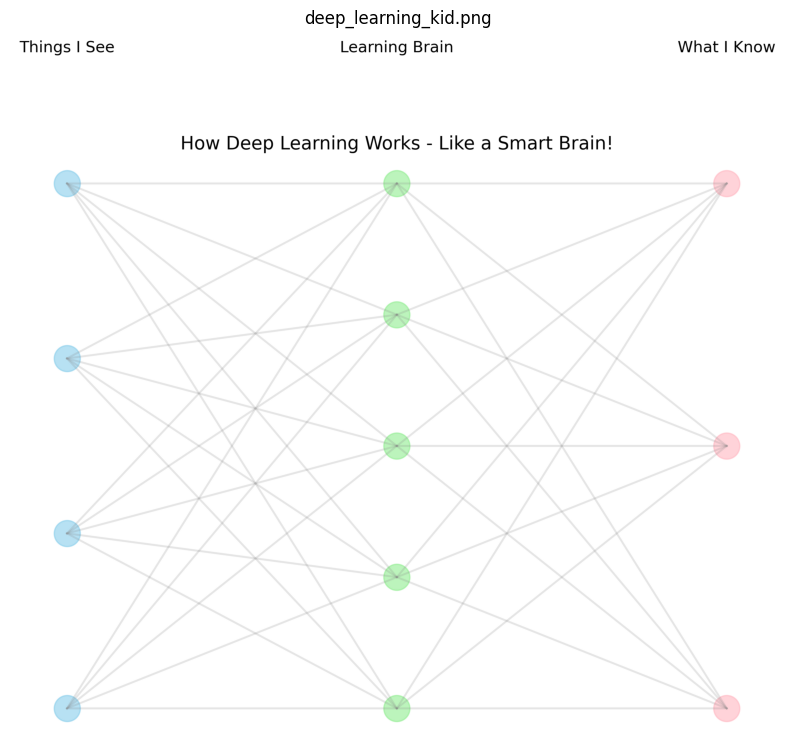

In [13]:
import io
from matplotlib import pyplot as plt

for content in result.messages[0].content:
    if content.type=="text":
        print(content.text.value)
    else:
        bytes_data=content.image_file.file_content
        img = plt.imread(io.BytesIO(bytes_data))
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(content.image_file.file_name)
        plt.show()
        plt.close()
    


for a in result.messages[0].attachments:
    if a.file_type=='text/csv':
        with open(a.file_name, 'wb') as f:
            f.write(a.file_content)
            print(f"File '{a.file_name}' saved to disk.")
        